In [22]:
import os
import psycopg2
from dotenv import load_dotenv
from sshtunnel import SSHTunnelForwarder
import time
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load environment variables from .env file
load_dotenv("environment_variables.env")
psql_pw = os.getenv("PSQL_PW")

# Get data
## DB Connection

In [3]:
# Connect to AWS RDS instance through AWS EC2 instance

# SSH parameters
bastion_host = 'ec2-34-224-93-62.compute-1.amazonaws.com'
bastion_user = 'ec2-user'
bastion_key = 'C:\\Users\\detto\\Documents\\ec2-key-pair.pem'

# RDS parameters
rds_host = 'youtubeviewprediction.cd0c8oow2pnr.us-east-1.rds.amazonaws.com'
rds_user = 'postgres'
rds_password = psql_pw
rds_database = 'YouTubeViewPrediction'
rds_port = 5432

try:
    # Create an SSH tunnel
    tunnel = SSHTunnelForwarder(
        (bastion_host, 22),
        ssh_username=bastion_user,
        ssh_pkey=bastion_key,
        remote_bind_address=(rds_host, rds_port),
        local_bind_address=('localhost', 6543)  # Choose a local port for the tunnel
    )

    # Start the tunnel
    tunnel.start()

    # Connect to PostgreSQL through the tunnel
    conn = psycopg2.connect(
        database=rds_database,
        user=rds_user,
        password=rds_password,
        host=tunnel.local_bind_host,
        port=tunnel.local_bind_port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a SQL query
    cursor.execute("SELECT version();")

    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record)

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
    tunnel.stop()

You are connected to -  ('PostgreSQL 16.1 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-12), 64-bit',)


## Turn SQL tables in to Pandas dataframes

In [4]:
video_fact = pd.read_sql_query("SELECT * FROM video_fact", conn)
video_dim = pd.read_sql_query("SELECT * FROM video_dim", conn)
channel_fact = pd.read_sql_query("SELECT * FROM channel_fact", conn)
channel_dim = pd.read_sql_query("SELECT * FROM channel_dim", conn)
categories_dim = pd.read_sql_query("SELECT * FROM categories_dim", conn)

In [5]:
conn.close()
cursor.close()
tunnel.stop()

# EDA
## video_fact table

In [6]:
video_fact.shape

(64280, 5)

In [7]:
video_fact.dtypes

collected_at    datetime64[ns]
video_id                object
num_views                int64
num_likes                int64
num_comments             int64
dtype: object

In [8]:
video_fact.describe()

,num_views,num_likes,num_comments
count,6.428000e+04,6.428000e+04,64280.000000
mean,2.972511e+06,1.169051e+05,7783.518326
std,1.157340e+07,5.351147e+05,29956.764451
min,3.034000e+04,0.000000e+00,0.000000
25%,4.750160e+05,1.303025e+04,984.000000
50%,9.655450e+05,3.163800e+04,2440.000000
75%,2.068528e+06,7.710925e+04,4984.000000
max,2.166765e+08,8.288865e+06,385935.000000


In [9]:
video_fact[["collected_at", "video_id"]].nunique()

collected_at    136
video_id        741
dtype: int64

In [10]:
video_fact.isna().sum()

collected_at    0
video_id        0
num_views       0
num_likes       0
num_comments    0
dtype: int64

### video_id column

In [11]:
id_counts = video_fact["video_id"].value_counts()
id_counts

laNA2HgwYXU    136
_ZaLmIh4-Qg    136
GHtIxjKPP9w    136
j7YgKocz2W4    136
O_A8HdCDaWM    136
              ... 
kggCqLJnPCA      1
QhQ8TMTZtIU      1
RtWMeHIqif8      1
GiYAF6i40xU      1
guId-pRW8TE      1
Name: video_id, Length: 741, dtype: int64

Text(0, 0.5, 'Number of Time Points Collected')

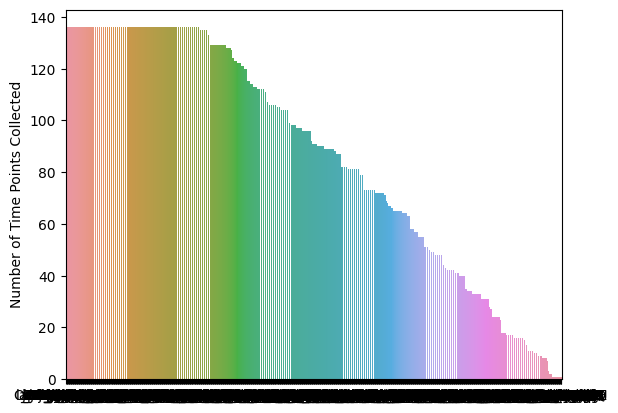

In [12]:
ax = sns.barplot(x=id_counts.index, y=id_counts)
ax.set_ylabel("Number of Time Points Collected")

In [13]:
id_counts2 = id_counts.value_counts()
id_counts2.sort_index(inplace=True, ascending=False)
id_counts2

136    200
135     13
133      1
131      1
129     24
      ... 
8        7
7        1
3        2
2        5
1       14
Name: video_id, Length: 85, dtype: int64

Text(0, 0.5, 'Number of Videos')

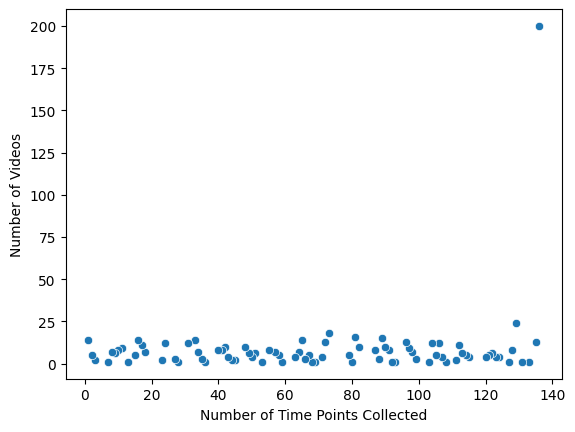

In [14]:
ax = sns.scatterplot(x=id_counts2.index, y=id_counts2)
ax.set_xlabel("Number of Time Points Collected")
ax.set_ylabel("Number of Videos")

#### Look at some individual time series

In [41]:
ids = id_counts.sample(30).index
print(ids)

Index(['nEP-_Ogi1bA', 'TYnxDv7FEPs', 'H58vbez_m4E', 'z_0Tt14KBJU',
       'NfMdvee5HoY', 'ySoHR8dFHGY', 'SuFYQoqHDVc', 'w3HZ3ior4_s',
       '9LUExu3qU-o', 'W10cztB9rvw', 'Xa8Mr-qL21o', 'pvey-kQdqqc',
       '_OKAwz2MsJs', 'CaPnJLSveE0', '2naeKHqaWBo', 'sidIL8V83Cc',
       'LbwKSw2UTq8', '_9CmC5Rmsdw', 'dsv8YGqw-hU', 'p6mhC5Iatns',
       'hH7TJMcxLFo', '1KpHSCPyZzE', 'Q_HXKmGIS3c', 'edWFA_i2DCA',
       '8kTlL0ycgyQ', 'ZWXKerrEYvQ', 'uFCXbpDoaus', 'nbs5jEOdpEI',
       'Lc57d8BTSpM', 'Hv9nQ2rOu6g'],
      dtype='object')


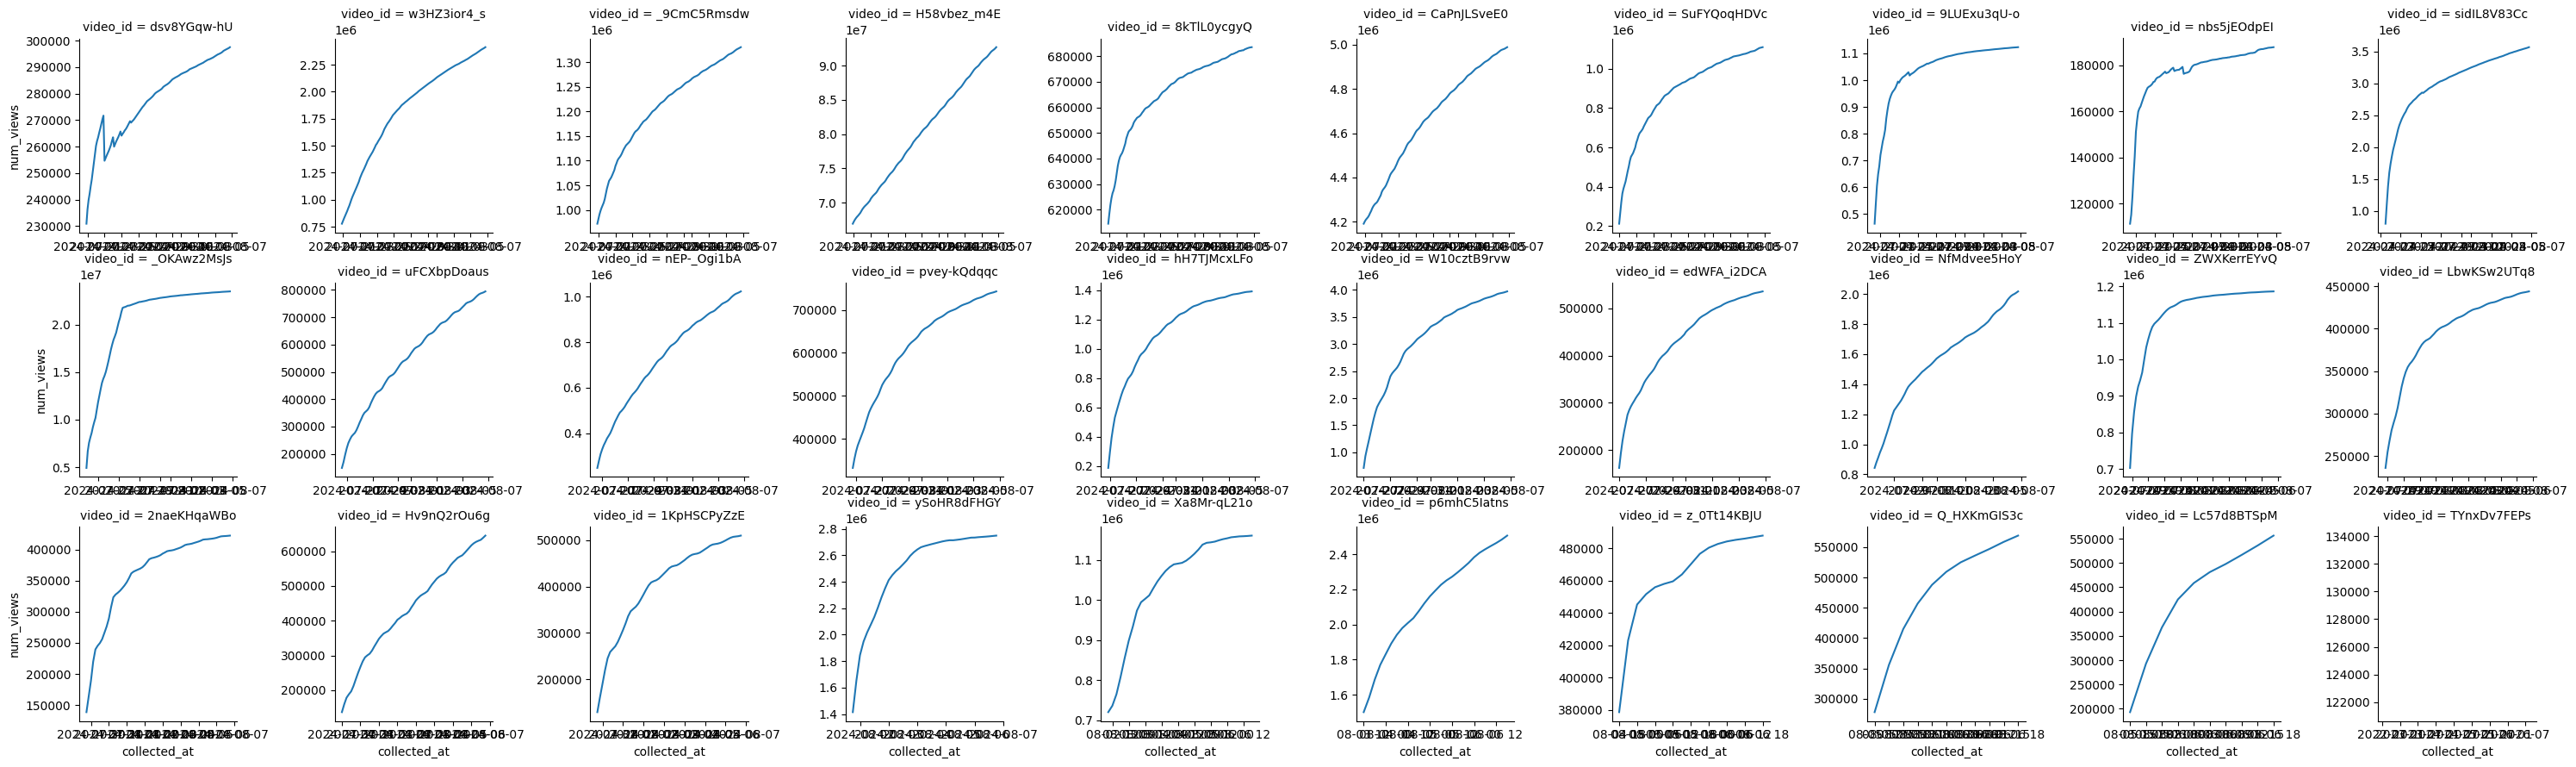

In [42]:
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", "num_views"]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=10)
g.map(sns.lineplot, "collected_at", "num_views")